In [1]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "C:/Users/bilge/Downloads/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)

# optional 1

df["data_point_number"] = df.index + 1

# optional 2

df  = mpt.counter_for_maintenance(df , "2020-02-01 00:00:00", f1_finish)
df  = mpt.counter_for_maintenance(df , f1_finish, f2_finish)
df  = mpt.counter_for_maintenance(df , f2_finish, f3_finish)
df  = mpt.counter_for_maintenance(df , f3_finish, f4_finish)
df = mpt.counter_for_maintenance(df, f4_finish, "2020-09-01 03:59:51")

#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =["counter",'data_point_number','TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)

# optional 3

df_clustered = mpt.apply_kmeans_clustering(df_scaled, 5, "condition")

In [3]:
def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    
    probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    probabilities = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)[0]
    y_test = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "no", use1, use2, use3, use4)[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    probabilities = mpt.get_the_probabilities_with_random_forest_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)[0]
    y_test = mpt.get_the_probabilities_with_random_forest_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "no", use1, use2, use3, use4)[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [4]:
df_back_up = df_clustered.copy()

In [5]:
df = df_back_up.copy()

df1 = df.copy() # best but suspicious

df2 = df.drop(labels = ["Cluster", "counter", "data_point_number"], axis = 1)  # OK but not suspicious

df3 = df.drop(labels = ["counter"], axis = 1) # the worst, do not even look at it

df4 = df.drop(labels = ["Cluster"], axis = 1)

df5 = df.drop(labels = ["Caudal_impulses", "Oil_level"], axis = 1)

df6 = df.drop(labels = ["TP2", "TP3", "Caudal_impulses", "Oil_level"], axis = 1)

df7 = df.drop(labels = ["TP2", "TP3", "Caudal_impulses", "Oil_level", "data_point_number"], axis = 1)

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                   Coefficient  p_value
data_point_number    11.537838      0.0
LPS                  -4.610285      0.0
Oil_temperature       4.422044      0.0
counter               4.175489      0.0
Motor_current        -3.185999      0.0
Cluster               2.381977      0.0
Reservoirs           -2.321912      0.0
H1                   -1.930984      0.0
DV_eletric           -1.793007      0.0
COMP                 -1.341479      0.0
MPG                  -1.211627      0.0
DV_pressure           0.945006      0.0
Pressure_switch       0.227688      0.0
Towers               -0.030090      0.0
Intercept: -15.604331376676965
R-squareddd: 0.9693225301119451
F-Value: 355877.14564461354


d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


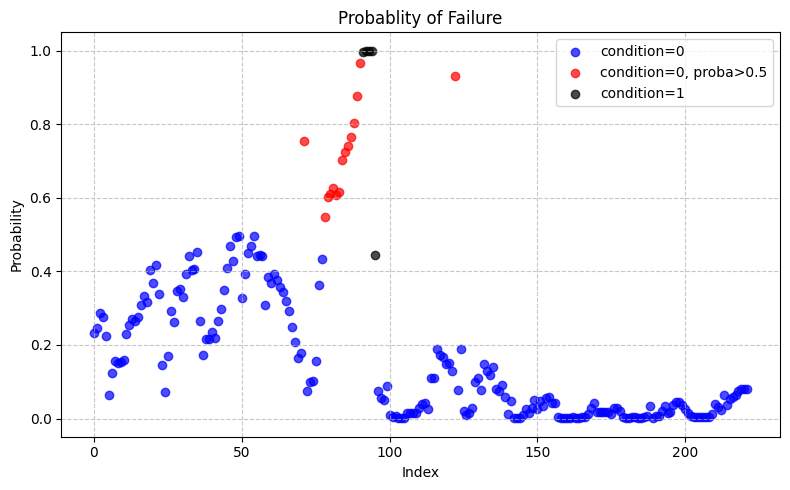

In [6]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df6

aggregated_probabilities = aggregate(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                        TP2       TP3        H1  DV_pressure  Reservoirs  \
TP2                1.000000  0.019995 -0.972392     0.743961    0.019355   
TP3                0.019995  1.000000  0.167035    -0.069652    0.999995   
H1                -0.972392  0.167035  1.000000    -0.744071    0.167630   
DV_pressure        0.743961 -0.069652 -0.744071     1.000000   -0.069470   
Reservoirs         0.019355  0.999995  0.167630    -0.069470    1.000000   
Oil_temperature    0.455046  0.299536 -0.396106     0.572927    0.300051   
Motor_current      0.745567  0.476267 -0.651596     0.559147    0.475696   
COMP              -0.857342  0.075118  0.868883    -0.656877    0.075676   
DV_eletric         0.857210  0.121633 -0.833339     0.656150    0.121131   
Towers            -0.489562  0.080520  0.506270    -0.372492    0.080862   
MPG               -0.760193 -0.064321  0.746902    -0.581653   -0.063856   
LPS                0.044540 -0.274891 -0.087437    -0.015535   -0.275576   


d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                        TP2       TP3        H1  DV_pressure  Reservoirs  \
TP2                1.000000  0.019995 -0.972392     0.743961    0.019355   
TP3                0.019995  1.000000  0.167035    -0.069652    0.999995   
H1                -0.972392  0.167035  1.000000    -0.744071    0.167630   
DV_pressure        0.743961 -0.069652 -0.744071     1.000000   -0.069470   
Reservoirs         0.019355  0.999995  0.167630    -0.069470    1.000000   
Oil_temperature    0.455046  0.299536 -0.396106     0.572927    0.300051   
Motor_current      0.745567  0.476267 -0.651596     0.559147    0.475696   
COMP              -0.857342  0.075118  0.868883    -0.656877    0.075676   
DV_eletric         0.857210  0.121633 -0.833339     0.656150    0.121131   
Towers            -0.489562  0.080520  0.506270    -0.372492    0.080862   
MPG               -0.760193 -0.064321  0.746902    -0.581653   -0.063856   
LPS                0.044540 -0.274891 -0.087437    -0.015535   -0.275576   


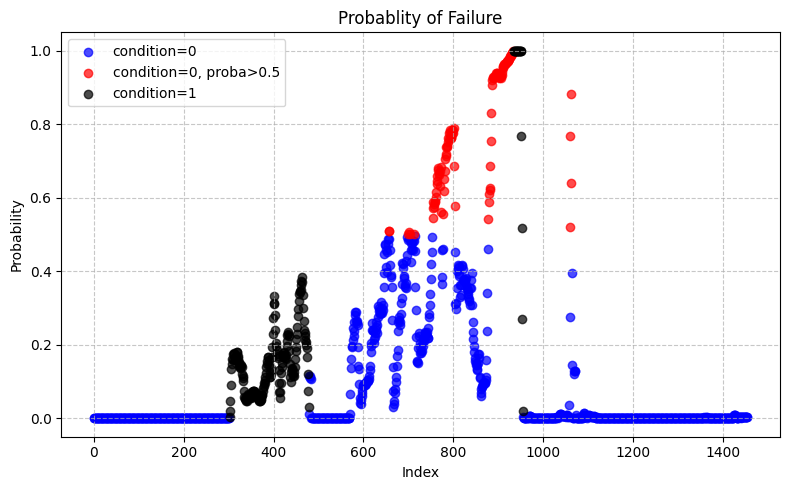

In [13]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df1

aggregated_probabilities = agg_new_deneme(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6, "yes", "yes", "no", "no", 100)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

                 Importance
counter            0.215750
DV_pressure        0.210848
Oil_temperature    0.180601
Reservoirs         0.108554
Motor_current      0.089913
Cluster            0.075225
H1                 0.062726
MPG                0.034657
COMP               0.012860
DV_eletric         0.007839
LPS                0.001004
Towers             0.000017
Pressure_switch    0.000005
R-squareddd: 0.9999853816680968
F-Value Like: 301718955.34550935


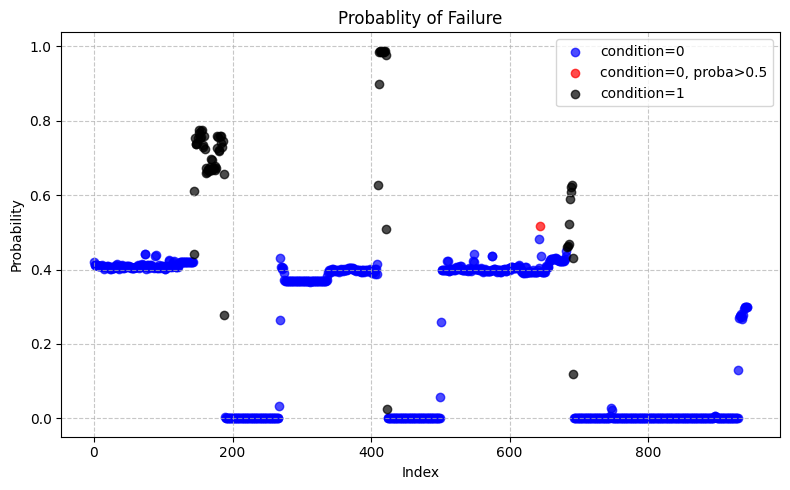

In [8]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df7

aggregated_probabilities = agg_random_forest(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6, "no", "no", "yes", "no", 200)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Code\Graduation-Project\mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)


                   Coefficient       p_value
data_point_number    10.259763  0.000000e+00
LPS                  -4.566236  0.000000e+00
counter               3.870814  0.000000e+00
Oil_temperature       2.935966  0.000000e+00
H1                   -2.198618  0.000000e+00
TP2                  -1.090071  0.000000e+00
Pressure_switch       1.089118  0.000000e+00
TP3                  -1.055056  0.000000e+00
DV_pressure           0.917147  0.000000e+00
Motor_current        -0.712929  0.000000e+00
COMP                 -0.638288  0.000000e+00
Reservoirs           -0.621559  0.000000e+00
MPG                  -0.402347  7.075635e-05
Oil_level            -0.244231           NaN
Caudal_impulses      -0.244231           NaN
DV_eletric           -0.078959  1.197203e-01
Towers               -0.005462  4.440892e-15
Intercept: -11.237676226678593
R-squareddd: 0.9654071728050545
F-Value: 258849.09155599482


d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Code\Graduation-Project\mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)


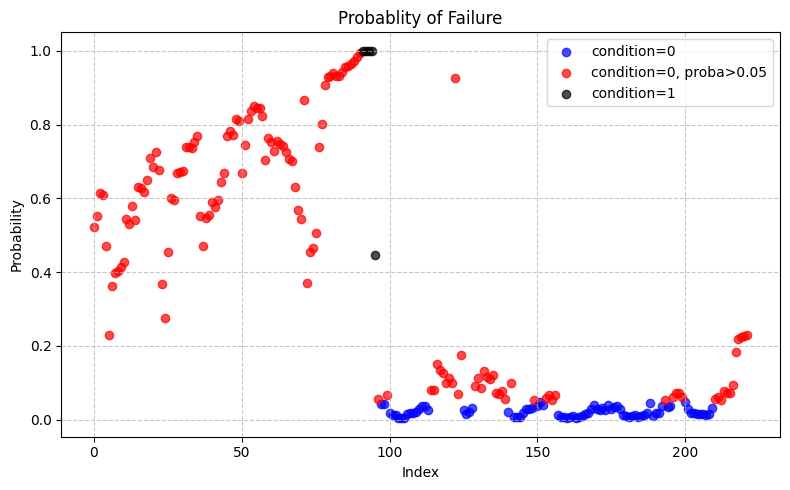

In [9]:
aggregation_size = 400

treshold_probability = 0.05

dataframe = df4

aggregated_probabilities = aggregate(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Code\Graduation-Project\mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)


                   Coefficient       p_value
data_point_number    10.259763  0.000000e+00
LPS                  -4.566236  0.000000e+00
counter               3.870814  0.000000e+00
Oil_temperature       2.935966  0.000000e+00
H1                   -2.198618  0.000000e+00
TP2                  -1.090071  0.000000e+00
Pressure_switch       1.089118  0.000000e+00
TP3                  -1.055056  0.000000e+00
DV_pressure           0.917147  0.000000e+00
Motor_current        -0.712929  0.000000e+00
COMP                 -0.638288  0.000000e+00
Reservoirs           -0.621559  0.000000e+00
MPG                  -0.402347  7.075635e-05
Oil_level            -0.244231           NaN
Caudal_impulses      -0.244231           NaN
DV_eletric           -0.078959  1.197203e-01
Towers               -0.005462  4.440892e-15
Intercept: -11.237676226678593
R-squareddd: 0.9654071728050545
F-Value: 258849.09155599482


d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Code\Graduation-Project\mpt_functions.py:418: RuntimeWarning: invalid value encountered in sqrt
  se_coef = np.sqrt(var_coef)


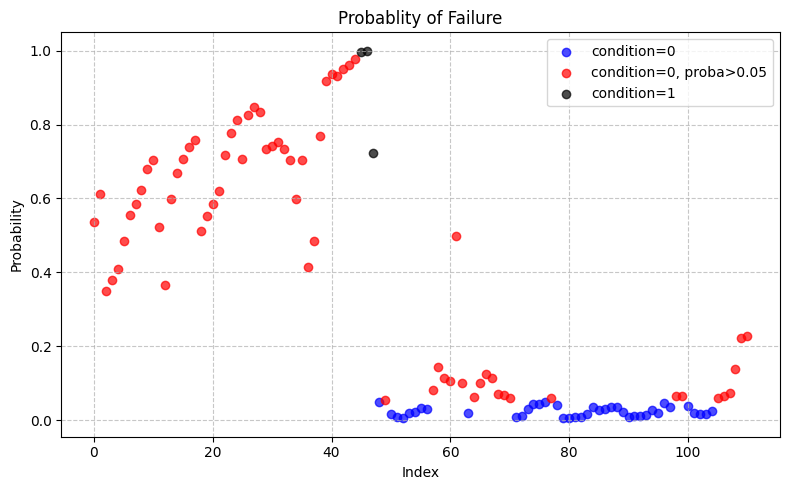

In [10]:
aggregation_size = 800

treshold_probability = 0.05

dataframe = df4

aggregated_probabilities = aggregate(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

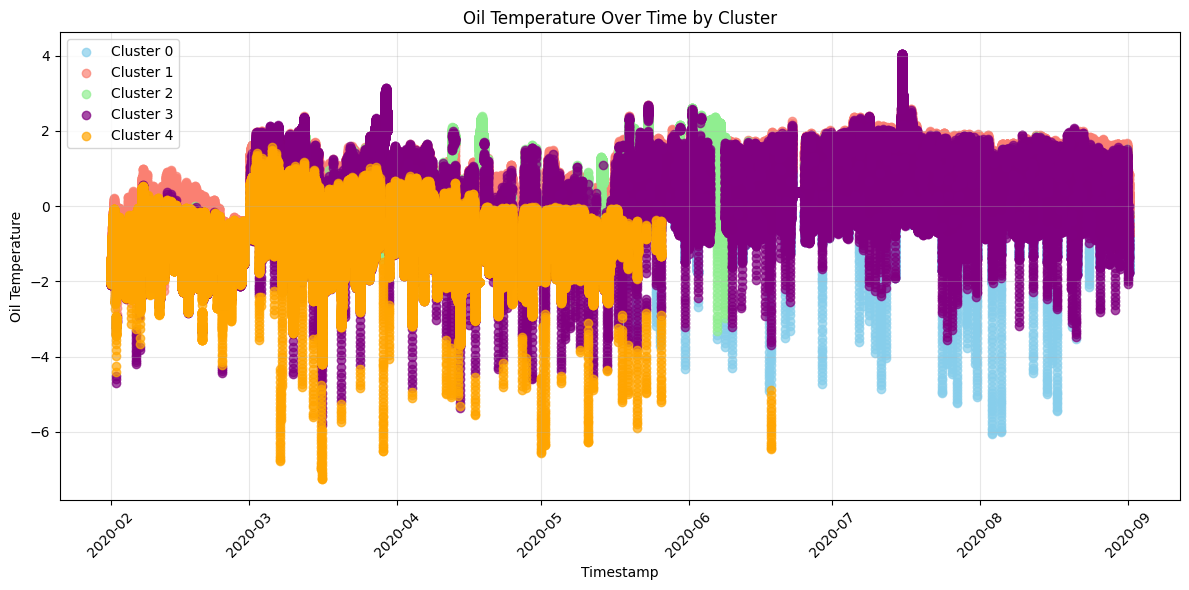

In [11]:
# Reset index if needed
df_plot = df_clustered.reset_index()

# Assuming df_clustered has:
# - A timestamp column (adjust name if different)
# - 'Oil_temperature' column
# - 'Cluster' column with cluster assignments

plt.figure(figsize=(12, 6))

# Define 5 distinct colors for the clusters
cluster_colors = ['skyblue', 'salmon', 'lightgreen', 'purple', 'orange']

# Create scatter plot with timestamps on x-axis, oil temp on y-axis
# and points colored by cluster
for i, cluster_id in enumerate(sorted(df_plot['Cluster'].unique())):
    cluster_data = df_plot[df_plot['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['timestamp'],  # x-axis: timestamps
        cluster_data['Oil_temperature'],  # y-axis: oil temperature
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        # Use the color from our list based on the index
        color=cluster_colors[i % len(cluster_colors)]  # The modulo ensures we don't go out of bounds
    )

plt.xlabel('Timestamp')
plt.ylabel('Oil Temperature')
plt.title('Oil Temperature Over Time by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # Rotate timestamp labels for better readability
plt.tight_layout()
plt.show()

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                        TP2       TP3        H1  DV_pressure  Reservoirs  \
TP2                1.000000 -0.194198 -0.970648     0.776794   -0.194711   
TP3               -0.194198  1.000000  0.372561    -0.341012    0.999996   
H1                -0.970648  0.372561  1.000000    -0.790301    0.373028   
DV_pressure        0.776794 -0.341012 -0.790301     1.000000   -0.340791   
Reservoirs        -0.194711  0.999996  0.373028    -0.340791    1.000000   
Oil_temperature    0.559629  0.086988 -0.514051     0.675438    0.087365   
Motor_current      0.786010  0.197473 -0.710438     0.622449    0.196949   
COMP              -0.910279  0.288366  0.927487    -0.742165    0.288830   
DV_eletric         0.910199 -0.181235 -0.908992     0.741799   -0.181672   
Towers            -0.535621  0.194252  0.553862    -0.433884    0.194532   
MPG               -0.850487  0.198631  0.854429    -0.692997    0.199046   
LPS                0.047244 -0.344290 -0.124139     0.040652   -0.344949   


d:\Anaconda\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                        TP2       TP3        H1  DV_pressure  Reservoirs  \
TP2                1.000000 -0.194198 -0.970648     0.776794   -0.194711   
TP3               -0.194198  1.000000  0.372561    -0.341012    0.999996   
H1                -0.970648  0.372561  1.000000    -0.790301    0.373028   
DV_pressure        0.776794 -0.341012 -0.790301     1.000000   -0.340791   
Reservoirs        -0.194711  0.999996  0.373028    -0.340791    1.000000   
Oil_temperature    0.559629  0.086988 -0.514051     0.675438    0.087365   
Motor_current      0.786010  0.197473 -0.710438     0.622449    0.196949   
COMP              -0.910279  0.288366  0.927487    -0.742165    0.288830   
DV_eletric         0.910199 -0.181235 -0.908992     0.741799   -0.181672   
Towers            -0.535621  0.194252  0.553862    -0.433884    0.194532   
MPG               -0.850487  0.198631  0.854429    -0.692997    0.199046   
LPS                0.047244 -0.344290 -0.124139     0.040652   -0.344949   


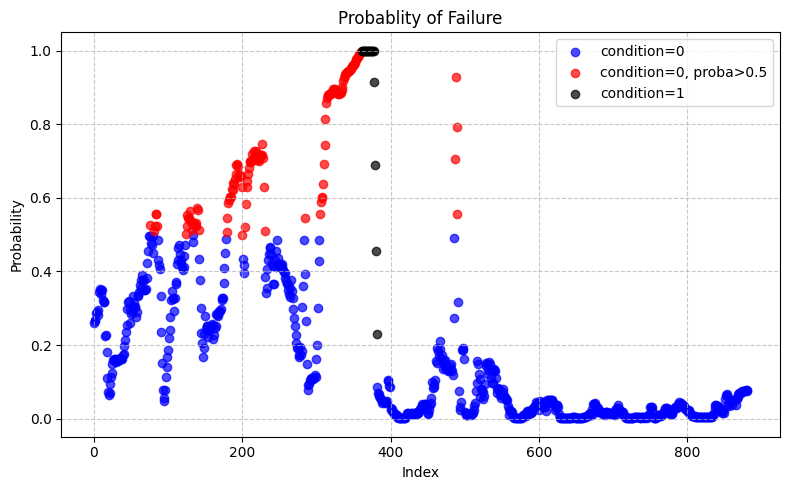

In [14]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df1

aggregated_probabilities = agg_new_deneme(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6, "yes", "yes", "yes", "no", 100)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

                     Importance
Oil_temperature    2.413508e-01
DV_pressure        2.160159e-01
H1                 1.097526e-01
TP2                1.066129e-01
Motor_current      9.582652e-02
counter            6.662822e-02
Cluster            5.501419e-02
TP3                2.630572e-02
COMP               2.144529e-02
data_point_number  2.121448e-02
Reservoirs         1.776670e-02
DV_eletric         1.586709e-02
MPG                4.536623e-03
Oil_level          9.715380e-04
LPS                6.699768e-04
Towers             1.633844e-05
Pressure_switch    5.175968e-06
Caudal_impulses    1.609164e-10
R-squareddd: 0.9999580110198264
F-Value Like: 208613438.11357248


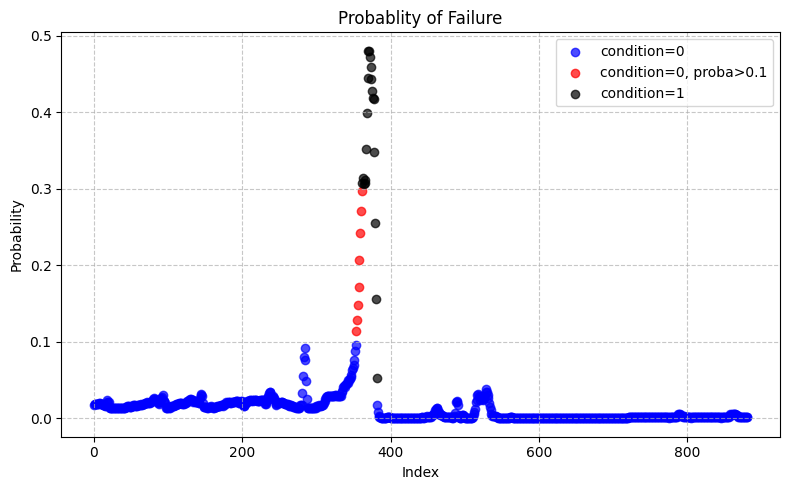

In [17]:
aggregation_size = 400

treshold_probability = 0.1

dataframe = df1

aggregated_probabilities = agg_random_forest(dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 6, 6, "yes", "yes", "yes", "no", 100)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)